## Backtesting
### Implementación de una cartera histórica
En este cuaderno mostramos como implementar de forma eficiente una cartera de inversión
que registra diariamente sus posiciones y la valoración. Las ideas centrales son:
- Simular con posiciones y valoración es una alternativa más realista frente a simplemente componer los retornos de una estrategia
    - Se pueden incorporar costes que no tengan un esquema proporcinal para todos los activos
    - Se pueden considerar restricciones de volumen en la negociación
    - Se pueden implementar ajustes a la cartera que dependen de estados previos
- Cuando no hay operativa en cada punto de tiempo, trabajar con las diferencias en las posiciones/caja nos permite mantener algunas ventajas de los cálculos eficientes que sean vectorizados 

____

In [75]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

### Datos 
Asumiremos por un tema se simplicidad en los ejemplos, que nuestro universo de acciones invertibles son las siguientes acciones del IBEX35.  

In [76]:
with open('../data/benchmark.pkl', 'rb') as handle:
    benchmarks = pickle.load(handle)
benchmark = benchmarks['ibex_div'].close

In [77]:
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

Construimos un dataframe con los precios de cierre

In [78]:
close_series = {ticker: df.close
                for ticker, df in stock_data.items()}
stock_df = pd.DataFrame(close_series)
stock_df = stock_df.loc['2017':]
stock_df = stock_df.dropna(how='all', axis=1)

In [79]:
stock_df.head()

,SAN,BKIA,NTGY,TRE,ACX,FER,ACS,ELE,SAB,AMS,...,IDR,SGRE,MEL,TL5,REE,COL,TEF,CABK,DIA,ALM
2017-01-02,4.288476,3.140887,15.380148,36.176445,10.985107,15.018059,25.048307,16.045344,1.171233,40.814804,...,10.545,16.206076,10.661235,9.562006,14.565837,NaN,7.594101,2.748946,1.252047,NaN
2017-01-03,4.392465,3.275359,15.324361,35.957842,11.115675,15.436924,25.105532,16.025510,1.209691,40.885288,...,10.610,16.164734,10.570562,9.532191,14.449225,NaN,7.667897,2.834258,1.237887,NaN
2017-01-04,4.412232,3.278561,15.139834,35.618310,11.072152,15.349660,24.737656,15.827175,1.201825,40.885288,...,10.455,16.106855,10.804403,9.519414,14.144944,NaN,7.682484,2.822193,1.232381,NaN
2017-01-05,4.425123,3.307376,15.109794,35.799704,11.059095,15.541640,24.709043,15.850975,1.200077,41.233008,...,10.570,16.032440,10.790086,9.574784,14.264189,NaN,7.845521,2.856663,1.231594,NaN
2017-01-06,4.450046,3.297771,15.187038,36.195050,11.046039,15.633267,24.741743,15.902542,1.214062,40.993363,...,10.630,16.090318,10.761453,9.591821,14.144944,NaN,7.890142,2.850631,1.238674,NaN


In [80]:
open_series = {ticker: df.open
                for ticker, df in stock_data.items()}
open_df = pd.DataFrame(open_series)
open_df = open_df.loc['2017':]
open_df = open_df.dropna(how='all', axis=1)

In [81]:
open_df.head()

,SAN,BKIA,NTGY,TRE,ACX,FER,ACS,ELE,SAB,AMS,...,IDR,SGRE,MEL,TL5,REE,COL,TEF,CABK,DIA,ALM
2017-01-02,4.229177,3.105668,15.384440,36.260165,11.002516,14.826079,24.525105,15.997744,1.159870,40.471783,...,10.30,15.933219,10.527612,9.527932,14.545550,NaN,7.510866,2.691209,1.223990,NaN
2017-01-03,4.297070,3.153694,15.414479,36.185747,11.037334,15.100959,25.146408,16.069144,1.173855,40.894686,...,10.58,16.288760,10.689869,9.574784,14.646596,NaN,7.615553,2.766180,1.255980,NaN
2017-01-04,4.411372,3.294569,15.285739,35.715984,11.128732,15.489282,25.121882,16.025510,1.216684,40.983965,...,10.61,16.135795,10.704186,9.604599,14.453337,NaN,7.688491,2.846322,1.242869,NaN
2017-01-05,4.403638,3.275359,15.079755,35.446219,10.989459,15.471829,24.737656,15.747841,1.201825,40.927578,...,10.41,16.040708,10.842581,9.527932,14.103825,NaN,7.657600,2.802373,1.235265,NaN
2017-01-06,4.413091,3.313780,15.096920,35.757844,11.028630,15.681262,24.770356,15.827175,1.195706,41.256503,...,10.50,16.065513,10.770997,9.557747,14.235406,NaN,7.854102,2.850631,1.234741,NaN


___

Registro de cambios de posición
 - las compras van como valores positivos
 - las ventas van como valores negativos   

In [82]:
delta_trades = pd.DataFrame(
    dtype=np.float,
    index=stock_df.index,
    columns=stock_df.columns
)
delta_trades.head()

,SAN,BKIA,NTGY,TRE,ACX,FER,ACS,ELE,SAB,AMS,...,IDR,SGRE,MEL,TL5,REE,COL,TEF,CABK,DIA,ALM
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


____
### Estrategia con Medias Móviles


Hacemos una función que calcule las señales de entrada y salida

In [83]:
def movaverage_states(vseries, win):
    sma = vseries.rolling(win).mean()
    signal_states = (vseries > sma).astype(float)
    trading_states = signal_states.shift(1)
    trading_states.iloc[0] = 0
    return trading_states

In [84]:
def sma_signals(vseries, win):
    states = movaverage_states(vseries, win)
    signals = states.diff().dropna()
    return signals

In [85]:
win = 50
iseries = stock_df['SAN']
sma_states = movaverage_states(iseries, win)
signals = sma_states.diff().dropna()

In [86]:
signals[signals != 0]

2017-03-13    1.0
2017-05-19   -1.0
2017-05-22    1.0
2017-05-23   -1.0
2017-05-24    1.0
             ... 
2020-02-25   -1.0
2020-05-28    1.0
2020-06-01   -1.0
2020-06-02    1.0
2020-07-23   -1.0
Name: SAN, Length: 98, dtype: float64

Cada día podemos saber las compras y ventas

In [87]:
all_signals = stock_df.apply(sma_signals, win=win)
all_signals

,SAN,BKIA,NTGY,TRE,ACX,FER,ACS,ELE,SAB,AMS,...,IDR,SGRE,MEL,TL5,REE,COL,TEF,CABK,DIA,ALM
2017-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
2020-08-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
2020-08-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [88]:
row = all_signals.loc['2017-05-11']
row[row != 0]

TRE   -1.0
ELE   -1.0
POP    1.0
Name: 2017-05-11 00:00:00, dtype: float64

In [89]:
all_signals.any(axis=1)

2017-01-03    False
2017-01-04    False
2017-01-05    False
2017-01-06    False
2017-01-09    False
              ...  
2020-08-17     True
2020-08-18     True
2020-08-19     True
2020-08-20     True
2020-08-21     True
Length: 928, dtype: bool

_____
Verificamos que haya precio en cada señal

In [90]:
stock_df['TRE'].isna().any()

True

In [91]:
def check_prices(signals, prices):
    trading = signals[signals != 0]
    trade_prices = prices.loc[trading.index]
    return trade_prices.isna().any()

In [92]:
checks = {ticker: check_prices(all_signals[ticker], stock_df[ticker])
          for ticker in stock_df.columns}
pd.Series(checks)

SAN     False
BKIA    False
NTGY    False
TRE     False
ACX     False
FER     False
ACS     False
ELE     False
SAB     False
AMS     False
AENA    False
ITX     False
MTS     False
IAG     False
VIS     False
BBVA    False
MAP     False
CIE     False
MAS     False
IBE     False
ENG     False
REP     False
ABE     False
ANA     False
GRF     False
CLNX    False
MRL     False
BKT     False
POP     False
ENC     False
IDR     False
SGRE    False
MEL     False
TL5     False
REE     False
COL     False
TEF     False
CABK    False
DIA     False
ALM     False
dtype: bool

____
### Cartera Histórica

Elementos a considerar:
 - Un registro de cambios de posición (*delta_trades*)
 - Un registro de cambios de efectivo (*delta_cash*)
 - Las posiciones y la caja son la suma acumulada de los cambios
 - La valoraciones son las posiciones por el precio del día
 - Las inversiones son la suma de las valoraciones
 - El patrimonio de la estrategia son las inversiones más la caja
 
Opcionalmente se podrían incluir los costes explícitos en el proceso iterativo de la cartera

In [93]:
init_capital = 100_000

In [94]:
delta_cash = pd.Series(0, index=stock_df.index)
delta_cash.iloc[0] = init_capital
delta_shares = pd.DataFrame(0, index=stock_df.index, columns=stock_df.columns)

for idate, isignals in all_signals.iterrows():    
    daybuys = isignals[isignals == 1]
    daysells = isignals[isignals == -1]
    
    if daybuys.count() == 0 and daysells.count() == 0:
        continue

    # actualizar portfolio 
    cash = delta_cash.cumsum()
    posiciones = delta_shares.cumsum()
    valoracion = posiciones * stock_df
    inversiones = valoracion.sum(axis=1)
    equity = inversiones + cash
    
    day_cash = cash.loc[idate]
    # limite de asignación a un 10% de la cartera
    alloc_limit = equity.loc[idate] * 0.1

    in_money, out_money = 0, 0
    # compras
    if daybuys.count() > 0:
        tk_money = min(day_cash/daybuys.count(), alloc_limit)
        buy_shares = np.floor(tk_money/open_df.loc[idate, daybuys.index])
        out_money = (buy_shares * open_df.loc[idate, daybuys.index]).sum()
        delta_shares.loc[idate, daybuys.index] = buy_shares

    # ventas
    if daysells.count() > 0:
        sell_shares = posiciones.loc[idate, daysells.index]
        in_money = (sell_shares * open_df.loc[idate, daysells.index]).sum()
        delta_shares.loc[idate, daysells.index] = -sell_shares

    delta_cash.loc[idate] = in_money - out_money

In [95]:
# ultima actualizacion
cash = delta_cash.cumsum()
posiciones = delta_shares.cumsum()
valoracion = posiciones * stock_df
inversiones = valoracion.sum(axis=1)
equity = inversiones + cash

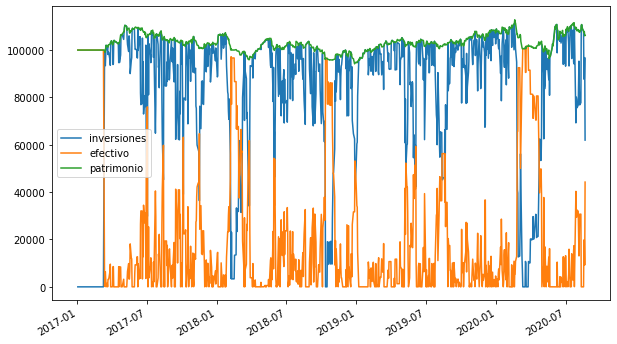

In [96]:
show_df = pd.DataFrame({
    'inversiones': inversiones,
    'efectivo': cash,
    'patrimonio': equity
})
show_df.plot(figsize=(10,6))

In [97]:
show_df.tail()

,inversiones,efectivo,patrimonio
2020-08-17,107961.5753,6.161324,107967.736624
2020-08-18,87670.4690,19819.006324,107489.475324
2020-08-19,87989.3702,19819.006324,107808.376524
2020-08-20,96817.4595,9211.006324,106028.465824
2020-08-21,61961.0950,44242.540324,106203.635324


In [98]:
bm = benchmark.reindex(stock_df.index)
pasive_invest = init_capital*(bm/bm.iloc[0])

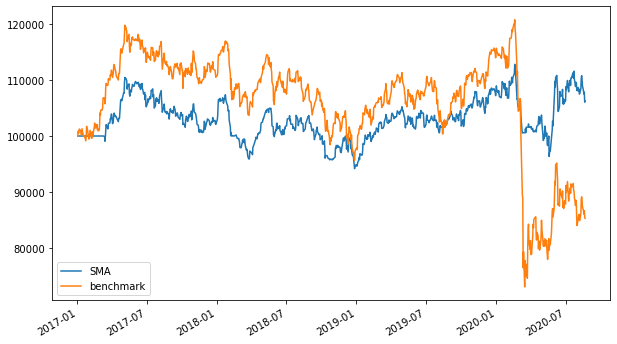

In [99]:
compare_df = pd.DataFrame({
    'SMA': equity,
    'benchmark': pasive_invest
})

compare_df.plot(figsize=(10,6))

**OJO**: Las estrategias de este estilo necesitan una ventana para construir sus primeras señales. A discreción tenemos que decidir.
 - Si la ventana inicial se considera o no para la comparación
 - Si construimos las señales a con precios fuera del punto de referencia para la inversión inicial

____

Verificamos ahora la el porcentaje de asignación de cada acción


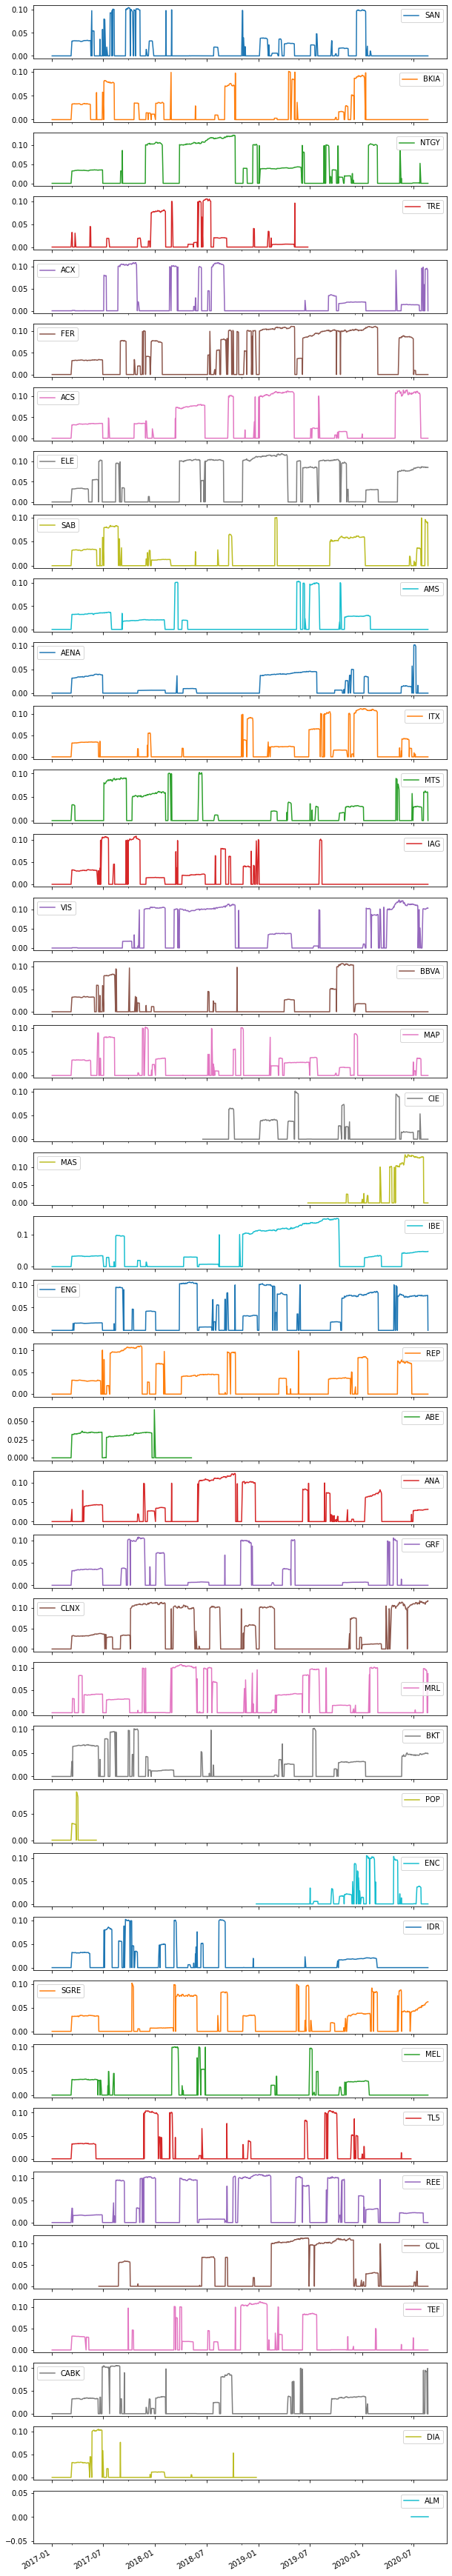

In [100]:
allocations = valoracion.div(equity, axis=0)
figs = allocations.plot(subplots=True, figsize=(10, 70))

____
### Ejercicio Propuesto (Opcional)
- Comparar el benchmark con la alternativa de utilizar los **precios de apertura** como forma
de adelantar la ejecución respecto a las señales de trading
- Implementar un esquema de comisiones que incluya 2euros + 0.02% sobre el efectivo en las operaciones de venta
